### 1. Предобработка данных

In [2]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from category_encoders.binary import BinaryEncoder
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.feature_selection import VarianceThreshold

In [3]:
file_path = 'data.tsv'
df_base = pd.read_csv(file_path, sep='\t')
df = df_base.copy()

In [4]:
df.head()

,Production_series,Optical_power,Price_rub,MKL_Diameter_mm,Manufacturer,Manufacture_country,Brand,Lens_type,Moisture_content_%,Oxygen_transmission_Dk/t,Package_quantity_pieces,Replacement_period,Wearing_mode,Curvature_radius,Refractive_range,Material
0,acuvue oasys with hydraclear plus,-1.00,1680,14.0,johnson&johnson,сша/ирландия,acuvue,прозрачные,38.0,147.0,6,две недели,дневной; допускается непрерывное ношение до 7 ...,8.4; 8.8,от -12.0d до +8.0d,силикон-гидрогель
1,air optix plus hydraglyde,-1.00,1380,14.2,alcon,малайзия/индонезия,airoptix,прозрачные,33.0,138.0,3,один месяц,дневной; допускается непрерывное ношение до 6 ...,8.6,от -12.0d до +8.0d,силикон-гидрогель
2,total30,-1.00,2120,NaN,alcon,германия,total,прозрачные,55.0,154.0,3,один месяц,дневной,8.4,от -12.0d до +6.0d,водоградиентный
3,precision1 for astigmatism,-1.25,2580,14.5,alcon,германия,precision,астигматические,87.0,90.0,30,один день,дневной,8.5,от -8.0d до +4.0d,силикон-гидрогель
4,total30 for astigmatism,-1.00,2580,NaN,alcon,германия,total,астигматические,55.0,123.0,3,один месяц,дневной,8.6,от -8.0d до +4.0d,водоградиентный


In [5]:
# Удалим дубликаты записей, если они присутствуют
df = df.drop_duplicates()

In [10]:
df.shape

(4005, 16)

#### Выбор целевого признака и подсчет дисбаланса классов

In [13]:
target_column = 'Replacement_period'

In [14]:
df[target_column].unique()

array(['две недели', 'один месяц', 'один день'], dtype=object)

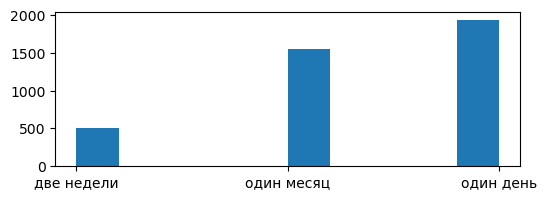

In [17]:
# Оценим дисбаланс классов для Replacement_period
fig, ax = plt.subplots(figsize=(6,2)) 
plt.hist(df[target_column])
plt.show()

In [18]:
df[target_column].value_counts()

Replacement_period
один день     1939
один месяц    1555
две недели     511
Name: count, dtype: int64

In [19]:
# посчитаем дисбаланс классов
total = df.shape[0]
class_0, class_1, class_2 = df[target_column].value_counts()
print(f'Класс 0 составляет {round(class_0 / total, 4)*100}%,\n класс 1 составляет {round(class_1 / total, 4)*100}%,\n класс 2 составляет {round(class_2 / total, 4)*100}%')

Класс 0 составляет 48.41%,
 класс 1 составляет 38.83%,
 класс 2 составляет 12.76%


##### Вывод. Дисбаланс классов присутствует, но является приемлемым.

#### Обработка пропусков

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4005 entries, 0 to 51112
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Production_series         4005 non-null   object 
 1   Optical_power             4004 non-null   float64
 2   Price_rub                 4005 non-null   int64  
 3   MKL_Diameter_mm           3623 non-null   float64
 4   Manufacturer              4005 non-null   object 
 5   Manufacture_country       4005 non-null   object 
 6   Brand                     4005 non-null   object 
 7   Lens_type                 4005 non-null   object 
 8   Moisture_content_%        4005 non-null   float64
 9   Oxygen_transmission_Dk/t  4005 non-null   float64
 10  Package_quantity_pieces   4005 non-null   int64  
 11  Replacement_period        4005 non-null   object 
 12  Wearing_mode              4005 non-null   object 
 13  Curvature_radius          4005 non-null   object 
 14  Refractive_r

In [26]:
df.describe()

,Optical_power,Price_rub,MKL_Diameter_mm,Moisture_content_%,Oxygen_transmission_Dk/t,Package_quantity_pieces
count,4004.000000,4005.000000,3623.000000,4005.000000,4005.000000,4005.000000
mean,-1.815622,2921.518102,14.193624,52.216180,98.425226,27.701124
std,5.058256,1729.364355,0.155413,14.384536,51.078716,33.680809
min,-20.000000,1040.000000,13.800000,24.000000,14.200000,2.000000
25%,-5.250000,1950.000000,14.100000,38.000000,42.000000,6.000000
50%,-2.000000,2440.000000,14.200000,55.000000,110.000000,12.000000
75%,2.250000,3140.000000,14.200000,58.000000,147.000000,30.000000
max,20.000000,12360.000000,14.500000,87.000000,175.000000,180.000000


In [27]:
df.isnull().sum()

Production_series             0
Optical_power                 1
Price_rub                     0
MKL_Diameter_mm             382
Manufacturer                  0
Manufacture_country           0
Brand                         0
Lens_type                     0
Moisture_content_%            0
Oxygen_transmission_Dk/t      0
Package_quantity_pieces       0
Replacement_period            0
Wearing_mode                  0
Curvature_radius              0
Refractive_range            267
Material                      0
dtype: int64

In [31]:
for col in df.columns:
    print(f'{col}: {df[col].isna().sum() / df.shape[0] * 100:.2f}%')

Production_series: 0.00%
Optical_power: 0.02%
Price_rub: 0.00%
MKL_Diameter_mm: 9.54%
Manufacturer: 0.00%
Manufacture_country: 0.00%
Brand: 0.00%
Lens_type: 0.00%
Moisture_content_%: 0.00%
Oxygen_transmission_Dk/t: 0.00%
Package_quantity_pieces: 0.00%
Replacement_period: 0.00%
Wearing_mode: 0.00%
Curvature_radius: 0.00%
Refractive_range: 6.67%
Material: 0.00%


In [32]:
df.shape

(4005, 16)

##### Количественные признаки

In [36]:
df['Optical_power'].value_counts()

Optical_power
-1.5     80
-4.5     80
-3.5     78
-5.5     78
-3.0     78
         ..
 10.5     1
 18.0     1
 17.0     1
 20.0     1
-17.5     1
Name: count, Length: 111, dtype: int64

In [38]:
df.dropna(subset=['Optical_power'], axis=0, inplace=True)
df.shape

(4004, 16)

##### Качественные признаки

In [41]:
df['MKL_Diameter_mm'].value_counts()

MKL_Diameter_mm
14.2    1720
14.0     756
14.5     493
14.1     317
14.3     293
13.8      43
Name: count, dtype: int64

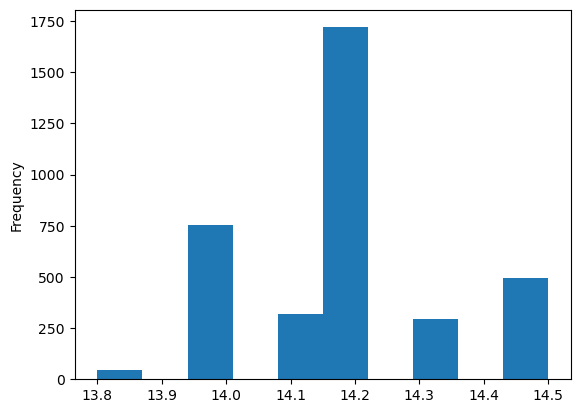

In [42]:
df['MKL_Diameter_mm'].plot(kind='hist', bins=10);

In [44]:
df['MKL_Diameter_mm'].mode()

0    14.2
Name: MKL_Diameter_mm, dtype: float64

In [45]:
df['MKL_Diameter_mm'].fillna(df['MKL_Diameter_mm'].mode().iloc[0], inplace=True)

In [46]:
# df['Refractive_range'].fillna('нет данных', inplace=True)

##### Удаление ненужных признаков

In [52]:
df.drop(['Refractive_range', 'Wearing_mode', 'Production_series', 'Curvature_radius', 'Manufacture_country'], axis=1, inplace=True)
df.head()

,Optical_power,Price_rub,MKL_Diameter_mm,Manufacturer,Brand,Lens_type,Moisture_content_%,Oxygen_transmission_Dk/t,Package_quantity_pieces,Replacement_period,Material
0,-1.00,1680,14.0,johnson&johnson,acuvue,прозрачные,38.0,147.0,6,две недели,силикон-гидрогель
1,-1.00,1380,14.2,alcon,airoptix,прозрачные,33.0,138.0,3,один месяц,силикон-гидрогель
2,-1.00,2120,14.2,alcon,total,прозрачные,55.0,154.0,3,один месяц,водоградиентный
3,-1.25,2580,14.5,alcon,precision,астигматические,87.0,90.0,30,один день,силикон-гидрогель
4,-1.00,2580,14.2,alcon,total,астигматические,55.0,123.0,3,один месяц,водоградиентный


In [53]:
df.isnull().sum()

Optical_power               0
Price_rub                   0
MKL_Diameter_mm             0
Manufacturer                0
Brand                       0
Lens_type                   0
Moisture_content_%          0
Oxygen_transmission_Dk/t    0
Package_quantity_pieces     0
Replacement_period          0
Material                    0
dtype: int64

In [54]:
df.shape

(4004, 11)

In [57]:
df.columns

Index(['Optical_power', 'Price_rub', 'MKL_Diameter_mm', 'Manufacturer',
       'Brand', 'Lens_type', 'Moisture_content_%', 'Oxygen_transmission_Dk/t',
       'Package_quantity_pieces', 'Replacement_period', 'Material'],
      dtype='object')

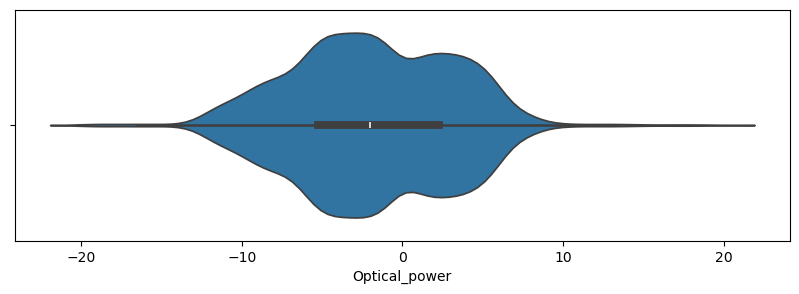

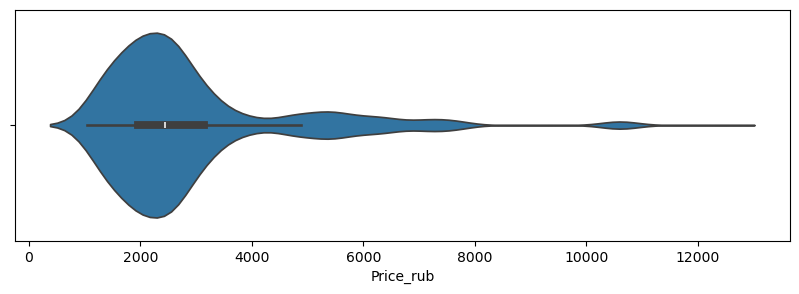

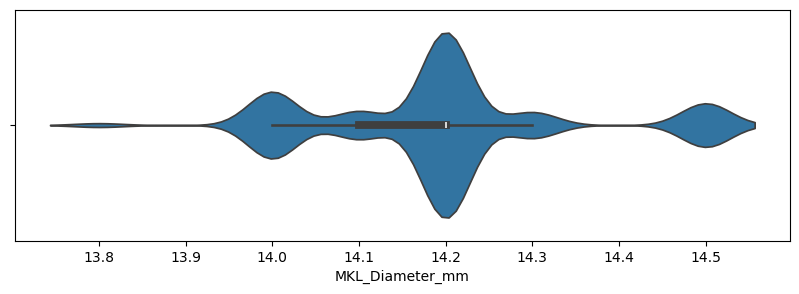

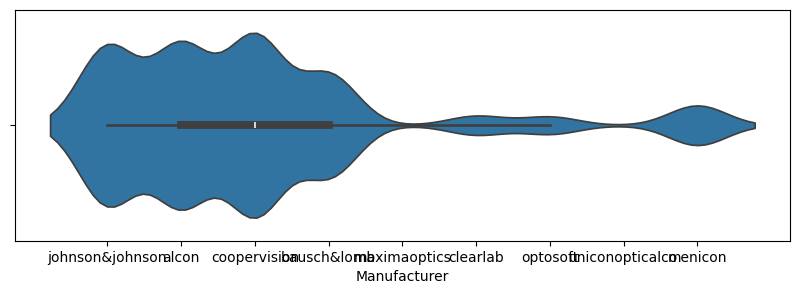

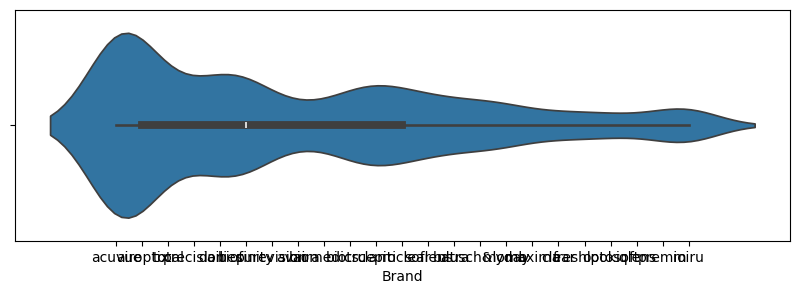

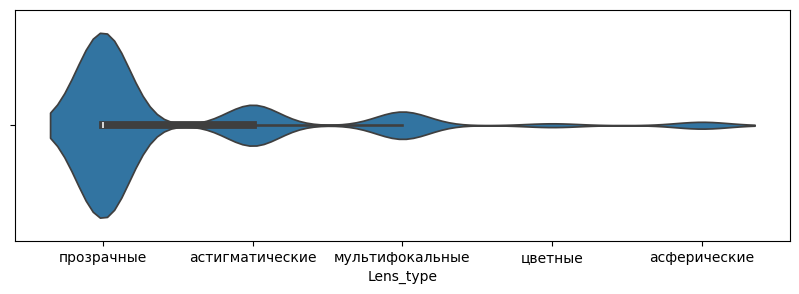

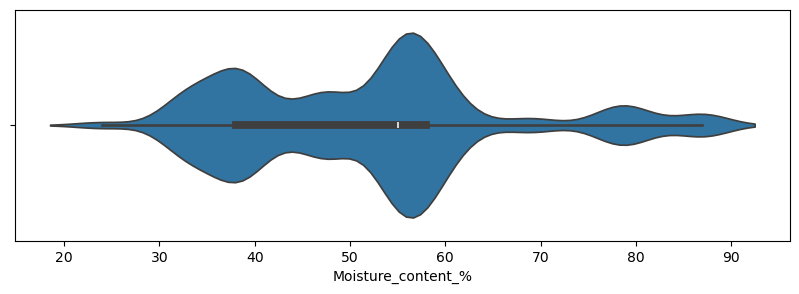

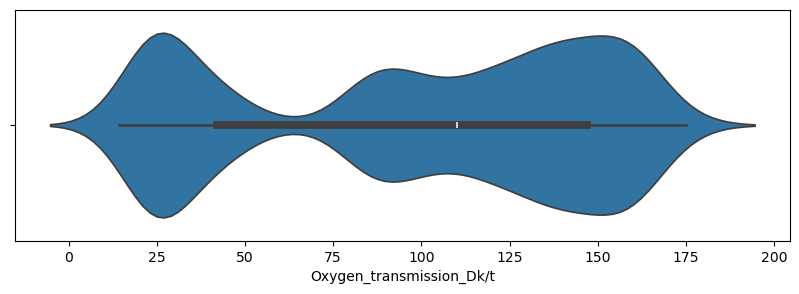

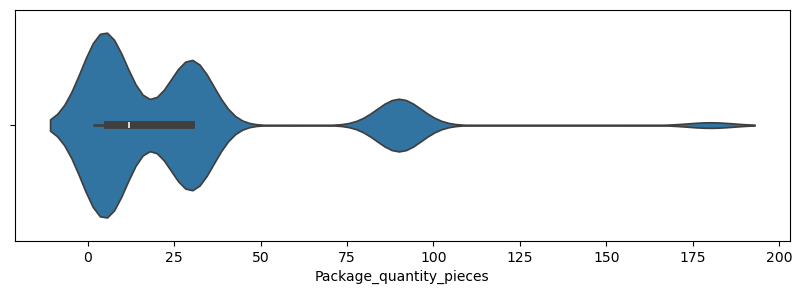

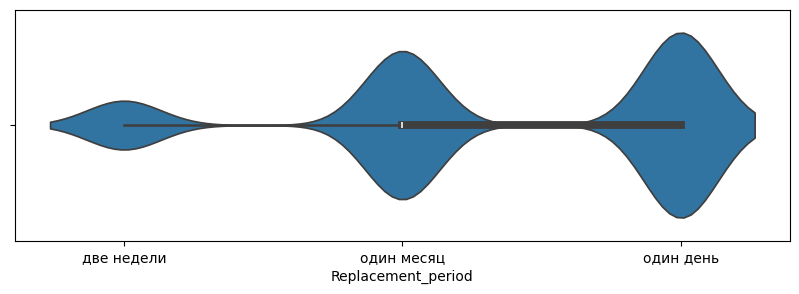

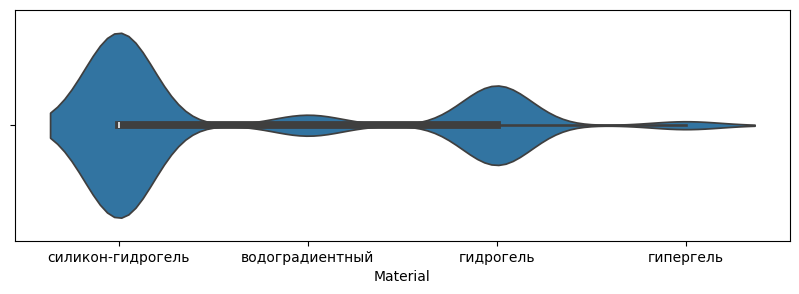

In [59]:
for col in df.columns:
    plt.figure(figsize=(10, 3))
    sns.violinplot(x=df[col])
    plt.show()

#### Преобразование целевой категории

##### Ordinal Encoding

In [63]:
# Replacement_period
# Создаем упорядоченный список категорий
Replacement_period = ['один день', 'две недели', 'один месяц']
# Инициализируем OrdinalEncoder
encoder = OrdinalEncoder(categories = [Replacement_period])

# Преобразуем столбец 'Optical_power'
df['Replacement_period'] = encoder.fit_transform(df[['Replacement_period']])

# df[['Optical_power','Optical_power_encoded']].head()

#### Преобразование нецелевых категорий

##### One-hot Encoding

In [66]:
# Package_quantity_pieces
# Инициализируем OneHotEncoder
encoder = OneHotEncoder(sparse_output = False)

# Преобразуем столбец 'Package_quantity_pieces'
onehot_columns = encoder.fit_transform(df[['Package_quantity_pieces']])

# Создаем датафрейм с новыми столбцами
encoded_df = pd.DataFrame(onehot_columns, columns=encoder.get_feature_names_out(['Package_quantity_pieces']))

encoded_columns_name = encoder.get_feature_names_out(['Package_quantity_pieces'])
df.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

df = pd.concat([df, encoded_df], axis=1)

df.drop('Package_quantity_pieces', axis = 1, inplace = True)
df.head()

,Optical_power,Price_rub,MKL_Diameter_mm,Manufacturer,Brand,Lens_type,Moisture_content_%,Oxygen_transmission_Dk/t,Replacement_period,Material,Package_quantity_pieces_2,Package_quantity_pieces_3,Package_quantity_pieces_6,Package_quantity_pieces_12,Package_quantity_pieces_24,Package_quantity_pieces_30,Package_quantity_pieces_90,Package_quantity_pieces_180
0,-1.00,1680,14.0,johnson&johnson,acuvue,прозрачные,38.0,147.0,1.0,силикон-гидрогель,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.00,1380,14.2,alcon,airoptix,прозрачные,33.0,138.0,2.0,силикон-гидрогель,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.00,2120,14.2,alcon,total,прозрачные,55.0,154.0,2.0,водоградиентный,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.25,2580,14.5,alcon,precision,астигматические,87.0,90.0,0.0,силикон-гидрогель,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-1.00,2580,14.2,alcon,total,астигматические,55.0,123.0,2.0,водоградиентный,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
# Lens_type
# Инициализируем OneHotEncoder
encoder = OneHotEncoder(sparse_output = False)

# Преобразуем столбец 'Lens_type'
onehot_columns = encoder.fit_transform(df[['Lens_type']])

# Создаем датафрейм с новыми столбцами
encoded_df = pd.DataFrame(onehot_columns, columns=encoder.get_feature_names_out(['Lens_type']))

encoded_columns_name = encoder.get_feature_names_out(['Lens_type'])
df.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

df = pd.concat([df, encoded_df], axis=1)

df.drop('Lens_type', axis = 1, inplace = True)
df.head()

,Optical_power,Price_rub,MKL_Diameter_mm,Manufacturer,Brand,Moisture_content_%,Oxygen_transmission_Dk/t,Replacement_period,Material,Package_quantity_pieces_2,...,Package_quantity_pieces_12,Package_quantity_pieces_24,Package_quantity_pieces_30,Package_quantity_pieces_90,Package_quantity_pieces_180,Lens_type_астигматические,Lens_type_асферические,Lens_type_мультифокальные,Lens_type_прозрачные,Lens_type_цветные
0,-1.00,1680,14.0,johnson&johnson,acuvue,38.0,147.0,1.0,силикон-гидрогель,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.00,1380,14.2,alcon,airoptix,33.0,138.0,2.0,силикон-гидрогель,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.00,2120,14.2,alcon,total,55.0,154.0,2.0,водоградиентный,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.25,2580,14.5,alcon,precision,87.0,90.0,0.0,силикон-гидрогель,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-1.00,2580,14.2,alcon,total,55.0,123.0,2.0,водоградиентный,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [68]:
# Manufacturer
# Инициализируем OneHotEncoder
encoder = OneHotEncoder(sparse_output = False)

# Преобразуем столбец 'Manufacturer'
onehot_columns = encoder.fit_transform(df[['Manufacturer']])

# Создаем датафрейм с новыми столбцами
encoded_df = pd.DataFrame(onehot_columns, columns=encoder.get_feature_names_out(['Manufacturer']))

encoded_columns_name = encoder.get_feature_names_out(['Manufacturer'])
df = pd.concat([df, encoded_df], axis=1)

df.drop('Manufacturer', axis = 1, inplace = True)
df.head()

,Optical_power,Price_rub,MKL_Diameter_mm,Brand,Moisture_content_%,Oxygen_transmission_Dk/t,Replacement_period,Material,Package_quantity_pieces_2,Package_quantity_pieces_3,...,Lens_type_цветные,Manufacturer_alcon,Manufacturer_bausch&lomb,Manufacturer_clearlab,Manufacturer_coopervision,Manufacturer_johnson&johnson,Manufacturer_maximaoptics,Manufacturer_menicon,Manufacturer_optosoft,Manufacturer_uniconopticalco
0,-1.00,1680,14.0,acuvue,38.0,147.0,1.0,силикон-гидрогель,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-1.00,1380,14.2,airoptix,33.0,138.0,2.0,силикон-гидрогель,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.00,2120,14.2,total,55.0,154.0,2.0,водоградиентный,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.25,2580,14.5,precision,87.0,90.0,0.0,силикон-гидрогель,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.00,2580,14.2,total,55.0,123.0,2.0,водоградиентный,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
# Material
# Инициализируем OneHotEncoder
encoder = OneHotEncoder(sparse_output = False)

# Преобразуем столбец 'Material'
onehot_columns = encoder.fit_transform(df[['Material']])

# Создаем датафрейм с новыми столбцами
encoded_df = pd.DataFrame(onehot_columns, columns=encoder.get_feature_names_out(['Material']))

encoded_columns_name = encoder.get_feature_names_out(['Material'])
df = pd.concat([df, encoded_df], axis=1)

df.drop('Material', axis = 1, inplace = True)
df.head()

,Optical_power,Price_rub,MKL_Diameter_mm,Brand,Moisture_content_%,Oxygen_transmission_Dk/t,Replacement_period,Package_quantity_pieces_2,Package_quantity_pieces_3,Package_quantity_pieces_6,...,Manufacturer_coopervision,Manufacturer_johnson&johnson,Manufacturer_maximaoptics,Manufacturer_menicon,Manufacturer_optosoft,Manufacturer_uniconopticalco,Material_водоградиентный,Material_гидрогель,Material_гипергель,Material_силикон-гидрогель
0,-1.00,1680,14.0,acuvue,38.0,147.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.00,1380,14.2,airoptix,33.0,138.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-1.00,2120,14.2,total,55.0,154.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-1.25,2580,14.5,precision,87.0,90.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.00,2580,14.2,total,55.0,123.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [70]:
# Brand
# Инициализируем OneHotEncoder
encoder = OneHotEncoder(sparse_output = False)

# Преобразуем столбец 'Brand'
onehot_columns = encoder.fit_transform(df[['Brand']])

# Создаем датафрейм с новыми столбцами
encoded_df = pd.DataFrame(onehot_columns, columns=encoder.get_feature_names_out(['Brand']))

encoded_columns_name = encoder.get_feature_names_out(['Brand'])
df = pd.concat([df, encoded_df], axis=1)

df.drop('Brand', axis = 1, inplace = True)
df.head()

,Optical_power,Price_rub,MKL_Diameter_mm,Moisture_content_%,Oxygen_transmission_Dk/t,Replacement_period,Package_quantity_pieces_2,Package_quantity_pieces_3,Package_quantity_pieces_6,Package_quantity_pieces_12,...,Brand_miru,Brand_myday,Brand_optosoft,Brand_precision,Brand_premio,Brand_proclear,Brand_purevision,Brand_soflens,Brand_total,Brand_ultra
0,-1.00,1680,14.0,38.0,147.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.00,1380,14.2,33.0,138.0,2.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.00,2120,14.2,55.0,154.0,2.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.25,2580,14.5,87.0,90.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.00,2580,14.2,55.0,123.0,2.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [71]:
df.shape

(4004, 55)

#### Масштабирование признаков

In [73]:
# Числовые колонки для масштабирования
scale_cols = ['Price_rub', 'MKL_Diameter_mm', 'Moisture_content_%', 'Oxygen_transmission_Dk/t', 'Optical_power']

In [74]:
scaler = MinMaxScaler()
scaler_data = scaler.fit_transform(df[scale_cols])

In [75]:
# Добавим масштабированные данные в набор данных
for i in range(len(scale_cols)):
    col = scale_cols[i]
    new_col_name = col + '_scaled'
    df[new_col_name] = scaler_data[:,i]

In [76]:
df.head()

,Optical_power,Price_rub,MKL_Diameter_mm,Moisture_content_%,Oxygen_transmission_Dk/t,Replacement_period,Package_quantity_pieces_2,Package_quantity_pieces_3,Package_quantity_pieces_6,Package_quantity_pieces_12,...,Brand_proclear,Brand_purevision,Brand_soflens,Brand_total,Brand_ultra,Price_rub_scaled,MKL_Diameter_mm_scaled,Moisture_content_%_scaled,Oxygen_transmission_Dk/t_scaled,Optical_power_scaled
0,-1.00,1680,14.0,38.0,147.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.056537,0.285714,0.222222,0.825871,0.47500
1,-1.00,1380,14.2,33.0,138.0,2.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.030035,0.571429,0.142857,0.769900,0.47500
2,-1.00,2120,14.2,55.0,154.0,2.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.095406,0.571429,0.492063,0.869403,0.47500
3,-1.25,2580,14.5,87.0,90.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.136042,1.000000,1.000000,0.471393,0.46875
4,-1.00,2580,14.2,55.0,123.0,2.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.136042,0.571429,0.492063,0.676617,0.47500


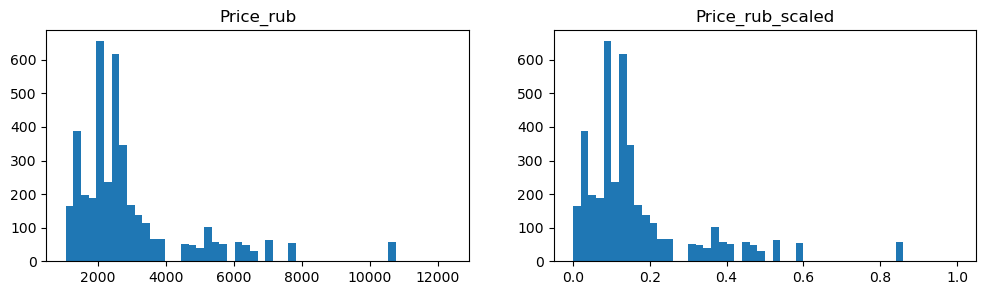

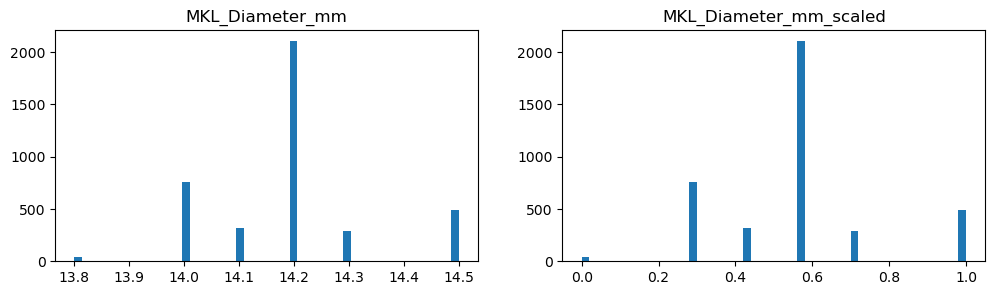

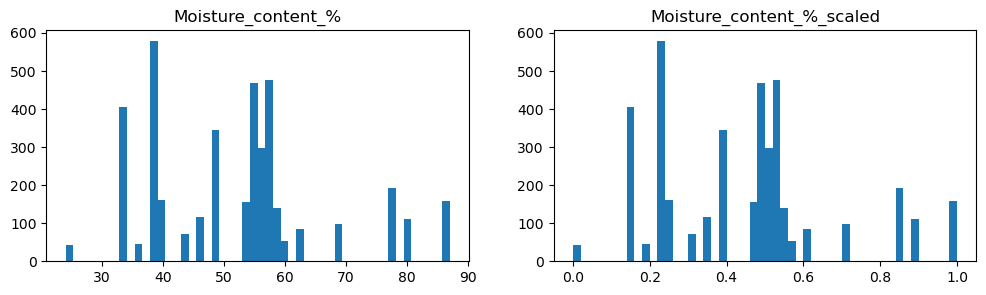

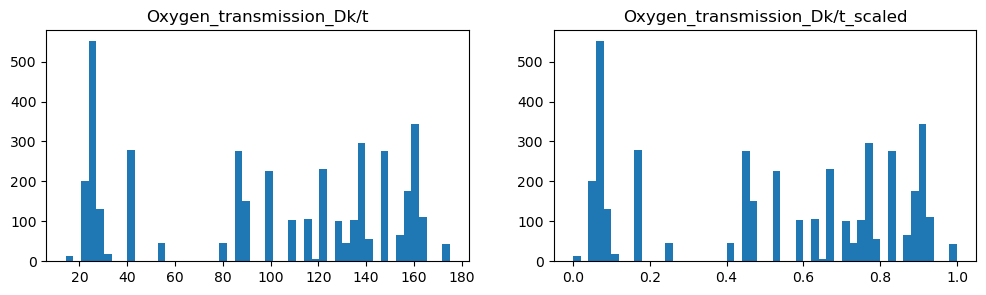

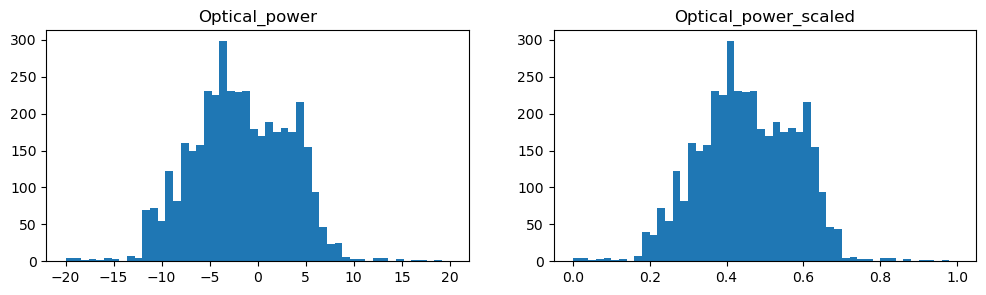

In [77]:
# Проверим, что масштабирование не повлияло на распределение данных
for col in scale_cols:
    col_scaled = col + '_scaled'

    fig, ax = plt.subplots(1, 2, figsize=(12,3))
    ax[0].hist(df[col], 50)
    ax[1].hist(df[col_scaled], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

In [78]:
df.drop(columns=scale_cols, axis = 1, inplace = True)

#### Отбор признаков

##### Удаление константных и псевдоконстантных (почти константных) признаков

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4004 entries, 0 to 4003
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Replacement_period               4004 non-null   float64
 1   Package_quantity_pieces_2        4004 non-null   float64
 2   Package_quantity_pieces_3        4004 non-null   float64
 3   Package_quantity_pieces_6        4004 non-null   float64
 4   Package_quantity_pieces_12       4004 non-null   float64
 5   Package_quantity_pieces_24       4004 non-null   float64
 6   Package_quantity_pieces_30       4004 non-null   float64
 7   Package_quantity_pieces_90       4004 non-null   float64
 8   Package_quantity_pieces_180      4004 non-null   float64
 9   Lens_type_астигматические        4004 non-null   float64
 10  Lens_type_асферические           4004 non-null   float64
 11  Lens_type_мультифокальные        4004 non-null   float64
 12  Lens_type_прозрачные

In [82]:
X = df.drop(columns=['Replacement_period'])
selector = VarianceThreshold(threshold=0.015)
selector.fit(X)
# Значения дисперсий для каждого признака
variances = selector.variances_
for var in variances:
    print(f"{var:.2f}")

0.01
0.15
0.21
0.01
0.01
0.22
0.12
0.01
0.13
0.03
0.09
0.21
0.01
0.18
0.13
0.03
0.19
0.18
0.00
0.06
0.03
0.00
0.07
0.20
0.03
0.23
0.18
0.09
0.03
0.03
0.08
0.01
0.05
0.06
0.03
0.06
0.00
0.00
0.00
0.04
0.04
0.03
0.04
0.01
0.03
0.01
0.04
0.03
0.03
0.02
0.04
0.05
0.10
0.02


In [83]:
X.head()

,Package_quantity_pieces_2,Package_quantity_pieces_3,Package_quantity_pieces_6,Package_quantity_pieces_12,Package_quantity_pieces_24,Package_quantity_pieces_30,Package_quantity_pieces_90,Package_quantity_pieces_180,Lens_type_астигматические,Lens_type_асферические,...,Brand_proclear,Brand_purevision,Brand_soflens,Brand_total,Brand_ultra,Price_rub_scaled,MKL_Diameter_mm_scaled,Moisture_content_%_scaled,Oxygen_transmission_Dk/t_scaled,Optical_power_scaled
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.056537,0.285714,0.222222,0.825871,0.47500
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.030035,0.571429,0.142857,0.769900,0.47500
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.095406,0.571429,0.492063,0.869403,0.47500
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.136042,1.000000,1.000000,0.471393,0.46875
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.136042,0.571429,0.492063,0.676617,0.47500


In [85]:
# Константный и псевдоконстантный признаки удалены
selector.transform(X)

array([[0.        , 1.        , 0.        , ..., 0.22222222, 0.82587065,
        0.475     ],
       [1.        , 0.        , 0.        , ..., 0.14285714, 0.7699005 ,
        0.475     ],
       [1.        , 0.        , 0.        , ..., 0.49206349, 0.86940299,
        0.475     ],
       ...,
       [0.        , 1.        , 0.        , ..., 0.25396825, 0.91293532,
        0.325     ],
       [0.        , 1.        , 0.        , ..., 0.25396825, 0.91293532,
        0.4       ],
       [0.        , 1.        , 0.        , ..., 0.25396825, 0.91293532,
        0.6       ]])

In [86]:
mask = selector.get_support()

In [88]:
selected_columns = X.columns[mask]
selected_columns

Index(['Package_quantity_pieces_3', 'Package_quantity_pieces_6',
       'Package_quantity_pieces_30', 'Package_quantity_pieces_90',
       'Lens_type_астигматические', 'Lens_type_асферические',
       'Lens_type_мультифокальные', 'Lens_type_прозрачные',
       'Manufacturer_alcon', 'Manufacturer_bausch&lomb',
       'Manufacturer_clearlab', 'Manufacturer_coopervision',
       'Manufacturer_johnson&johnson', 'Manufacturer_menicon',
       'Manufacturer_optosoft', 'Material_водоградиентный',
       'Material_гидрогель', 'Material_гипергель',
       'Material_силикон-гидрогель', 'Brand_acuvue', 'Brand_airoptix',
       'Brand_avaira', 'Brand_bausch&lomb', 'Brand_biofinity', 'Brand_biotruе',
       'Brand_clariti', 'Brand_clear', 'Brand_dailies', 'Brand_miru',
       'Brand_myday', 'Brand_optosoft', 'Brand_precision', 'Brand_proclear',
       'Brand_soflens', 'Brand_total', 'Brand_ultra', 'Price_rub_scaled',
       'MKL_Diameter_mm_scaled', 'Moisture_content_%_scaled',
       'Oxygen_trans

In [91]:
dropped_columns = X.columns[~mask]
dropped_columns

Index(['Package_quantity_pieces_2', 'Package_quantity_pieces_12',
       'Package_quantity_pieces_24', 'Package_quantity_pieces_180',
       'Lens_type_цветные', 'Manufacturer_maximaoptics',
       'Manufacturer_uniconopticalco', 'Brand_biomedics', 'Brand_freshlook',
       'Brand_iqlens', 'Brand_maxima', 'Brand_premio', 'Brand_purevision'],
      dtype='object')

In [94]:
df.drop(columns = dropped_columns, axis = 1, inplace = True)

In [100]:
df.head()

,Replacement_period,Package_quantity_pieces_3,Package_quantity_pieces_6,Package_quantity_pieces_30,Package_quantity_pieces_90,Lens_type_астигматические,Lens_type_асферические,Lens_type_мультифокальные,Lens_type_прозрачные,Manufacturer_alcon,...,Brand_precision,Brand_proclear,Brand_soflens,Brand_total,Brand_ultra,Price_rub_scaled,MKL_Diameter_mm_scaled,Moisture_content_%_scaled,Oxygen_transmission_Dk/t_scaled,Optical_power_scaled
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.056537,0.285714,0.222222,0.825871,0.47500
1,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.030035,0.571429,0.142857,0.769900,0.47500
2,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.095406,0.571429,0.492063,0.869403,0.47500
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.136042,1.000000,1.000000,0.471393,0.46875
4,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.136042,0.571429,0.492063,0.676617,0.47500


##### Удаление повторяющихся признаков

In [103]:
def get_duplicates(X):
    """
    Поиск дубликатов в колонках
    X - DataFrame
    """
    
    pairs = {}
    dups = []

    # Перебор всех колонок (внешний)
    for i in range(X.shape[1]):

        # текущая колонка
        feat_outer = X.columns[i]

        # если текущая колонка не является дублем
        if feat_outer not in dups:

            # создаем запись в словаре, колонка является ключом
            pairs[feat_outer] = []

            # Перебор оставшихся колонок (внутренний)
            for feat_inner in X.columns[i + 1:]:

                # Если колонки идентичны
                if X[feat_outer].equals(X[feat_inner]):

                    # добавление в словарь и список дубликатов
                    pairs[feat_outer].append(feat_inner)
                    dups.append(feat_inner)

    return pairs

In [104]:
get_duplicates(df)

{'Replacement_period': [],
 'Package_quantity_pieces_3': [],
 'Package_quantity_pieces_6': [],
 'Package_quantity_pieces_30': [],
 'Package_quantity_pieces_90': [],
 'Lens_type_астигматические': [],
 'Lens_type_асферические': ['Manufacturer_optosoft', 'Brand_optosoft'],
 'Lens_type_мультифокальные': [],
 'Lens_type_прозрачные': [],
 'Manufacturer_alcon': [],
 'Manufacturer_bausch&lomb': [],
 'Manufacturer_clearlab': ['Brand_clear'],
 'Manufacturer_coopervision': [],
 'Manufacturer_johnson&johnson': ['Brand_acuvue'],
 'Manufacturer_menicon': [],
 'Material_водоградиентный': [],
 'Material_гидрогель': [],
 'Material_гипергель': [],
 'Material_силикон-гидрогель': [],
 'Brand_airoptix': [],
 'Brand_avaira': [],
 'Brand_bausch&lomb': [],
 'Brand_biofinity': [],
 'Brand_biotruе': [],
 'Brand_clariti': [],
 'Brand_dailies': [],
 'Brand_miru': [],
 'Brand_myday': [],
 'Brand_precision': [],
 'Brand_proclear': [],
 'Brand_soflens': [],
 'Brand_total': [],
 'Brand_ultra': [],
 'Price_rub_scaled'

In [105]:
dropped_columns = ['Brand_acuvue', 'Manufacturer_optosoft', 'Brand_optosoft', 'Brand_clear']
df.drop(columns = dropped_columns, axis = 1, inplace = True) 

##### Методы, основанные на корреляции

<Axes: >

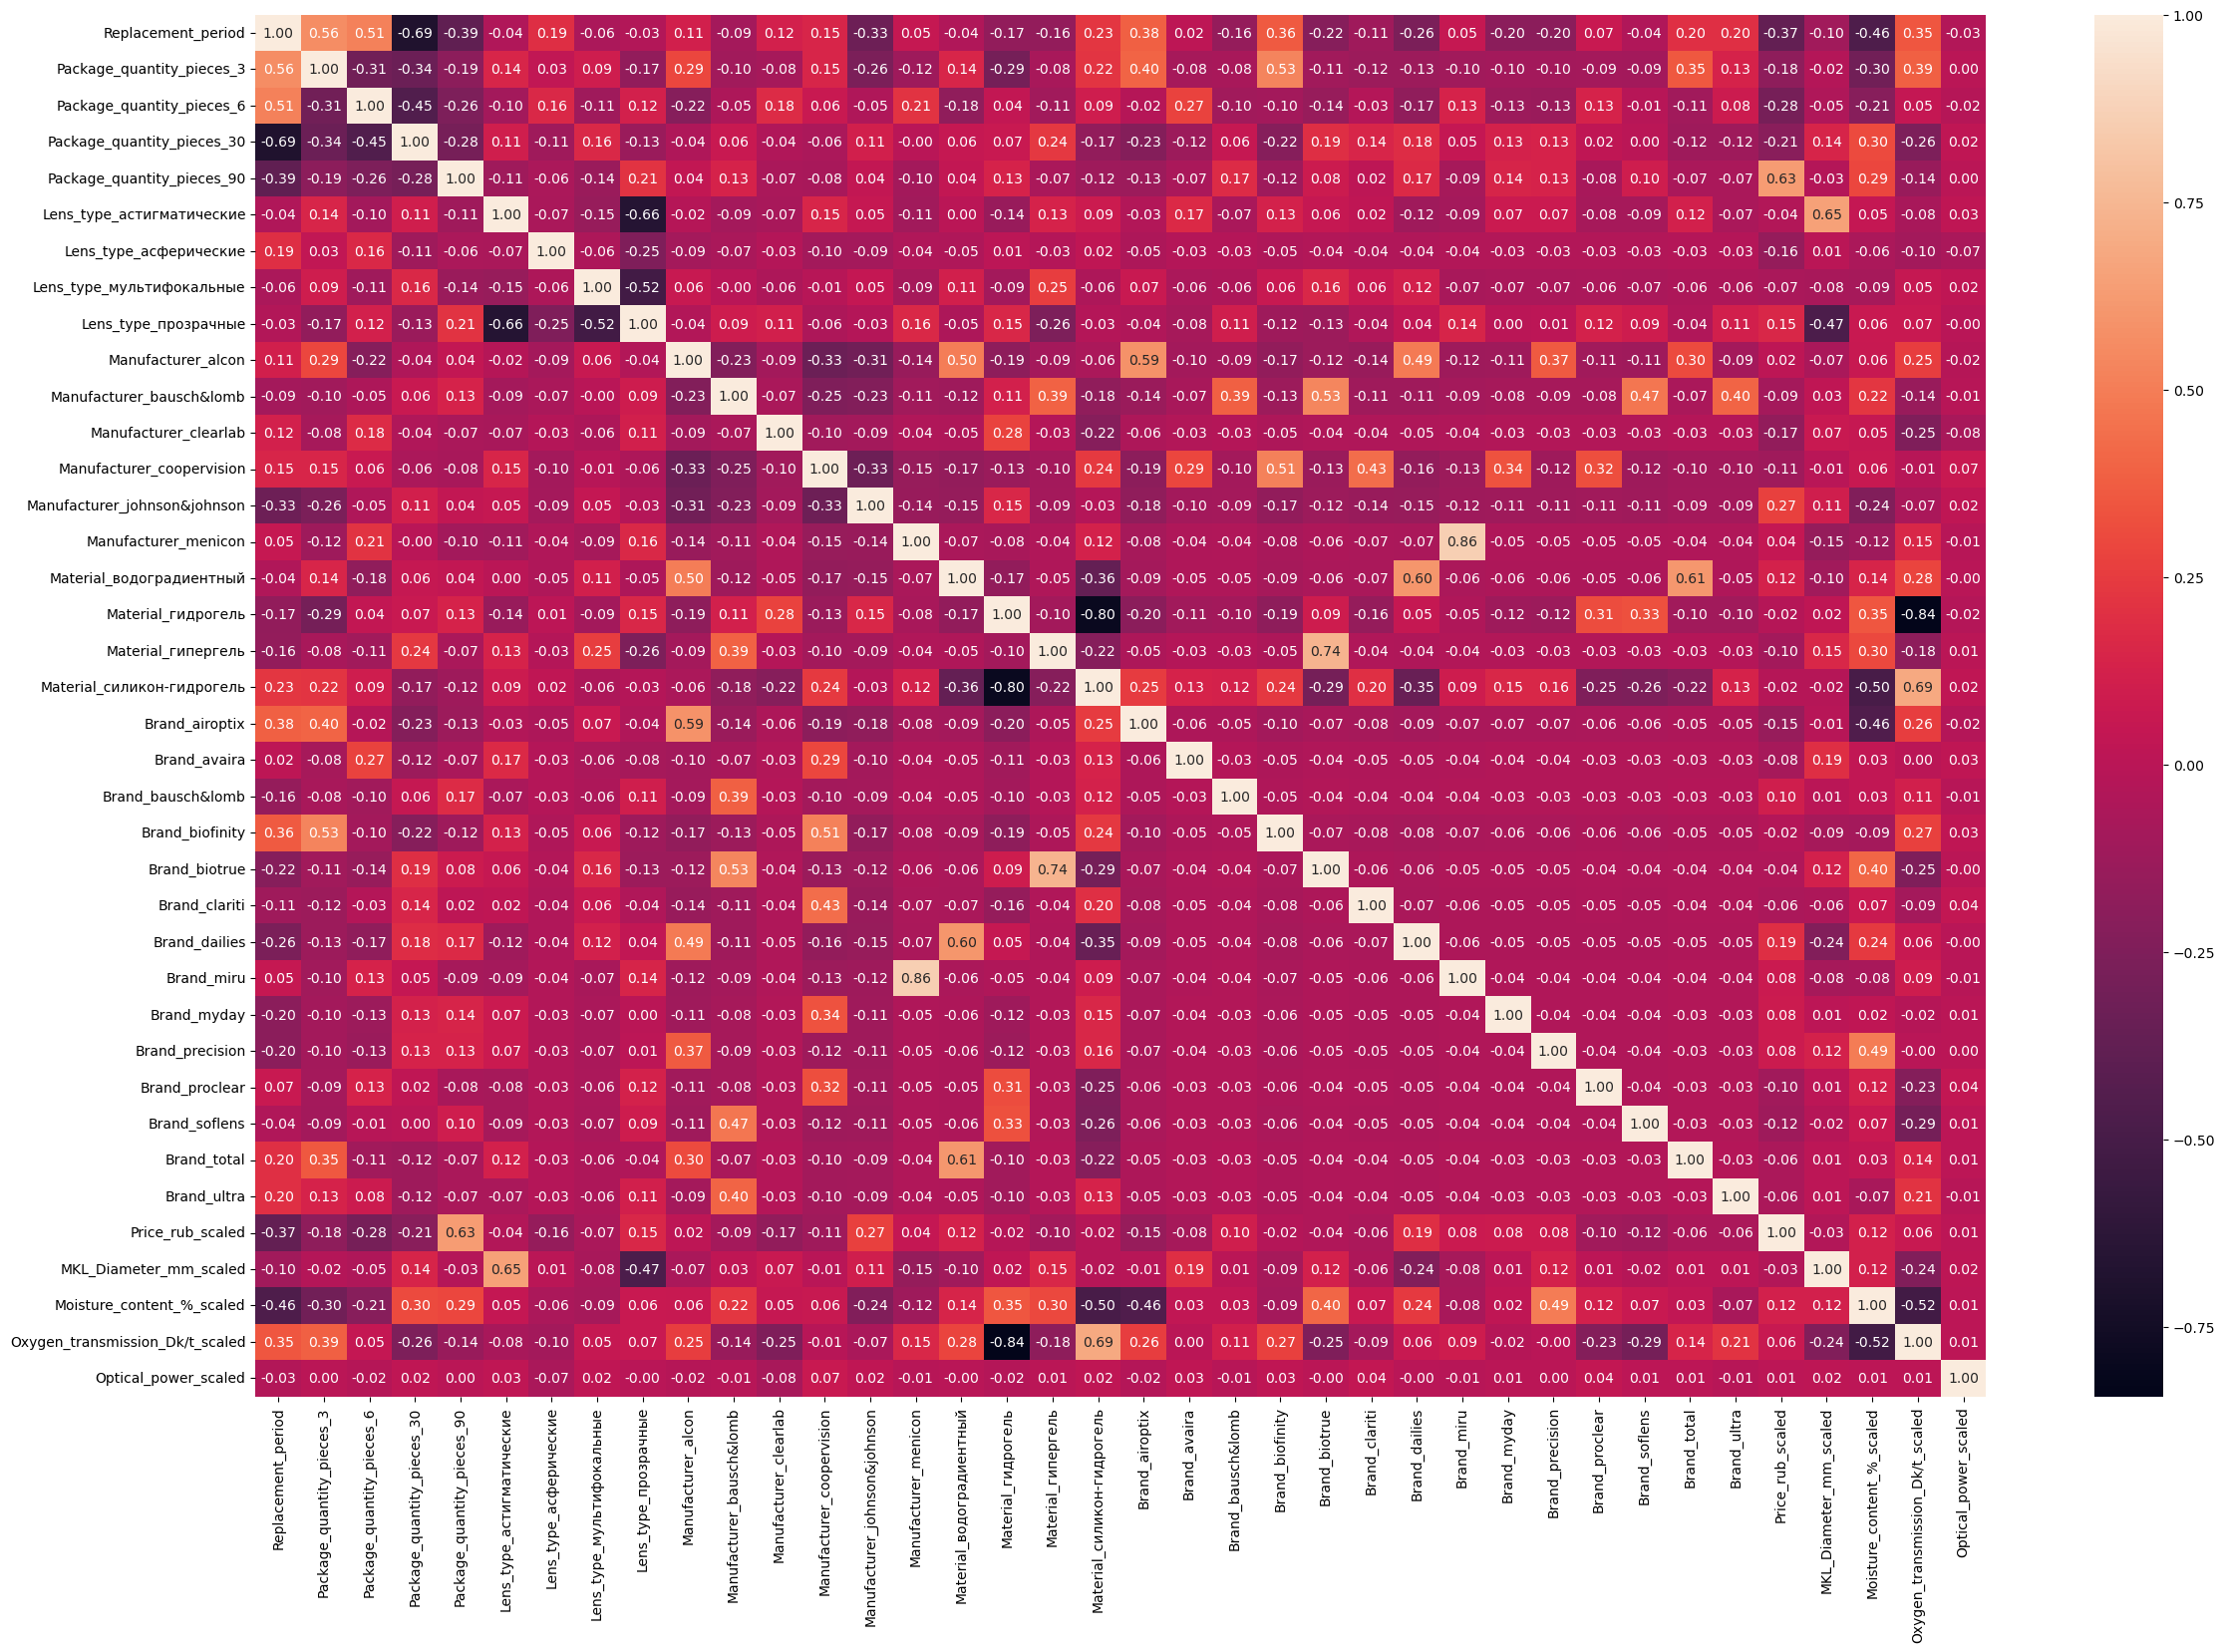

In [107]:
plt.figure(figsize=(28, 18))
sns.heatmap(df.corr(), annot=True, fmt='.2f')

In [108]:
# Формирование DataFrame с сильными корреляциями
def make_corr_df(df):
    cr = df.corr()
    cr = cr.abs().unstack() 
    cr = cr.sort_values(ascending=False)
    cr = cr[cr >= 0.7]
    cr = cr[cr < 1]
    cr = pd.DataFrame(cr).reset_index()
    cr.columns = ['f1', 'f2', 'corr']
    return cr

In [109]:
make_corr_df(df)

,f1,f2,corr
0,Manufacturer_menicon,Brand_miru,0.858004
1,Brand_miru,Manufacturer_menicon,0.858004
2,Oxygen_transmission_Dk/t_scaled,Material_гидрогель,0.843110
3,Material_гидрогель,Oxygen_transmission_Dk/t_scaled,0.843110
4,Material_силикон-гидрогель,Material_гидрогель,0.796531
5,Material_гидрогель,Material_силикон-гидрогель,0.796531
6,Material_гипергель,Brand_biotruе,0.739849
7,Brand_biotruе,Material_гипергель,0.739849


In [110]:
# Обнаружение групп коррелирующих признаков
def corr_groups(cr):
    grouped_feature_list = []
    correlated_groups = []

    for feature in cr['f1'].unique():
        if feature not in grouped_feature_list:
            # находим коррелирующие признаки
            correlated_block = cr[cr['f1'] == feature]
            cur_dups = list(correlated_block['f2'].unique()) + [feature]
            grouped_feature_list = grouped_feature_list + cur_dups
            correlated_groups.append(cur_dups)
    return correlated_groups

In [111]:
# Группы коррелирующих признаков
corr_groups(make_corr_df(df))

[['Brand_miru', 'Manufacturer_menicon'],
 ['Material_гидрогель', 'Oxygen_transmission_Dk/t_scaled'],
 ['Material_гидрогель', 'Material_силикон-гидрогель'],
 ['Brand_biotruе', 'Material_гипергель']]

In [112]:
dropped_columns = ['Material_силикон-гидрогель', 'Material_гидрогель', 'Manufacturer_menicon', 'Material_гипергель']
df.drop(columns = dropped_columns, axis = 1, inplace = True) 

In [121]:
# Удалим дубликаты записей, если они присутствуют
df = df.drop_duplicates()
df.shape

(4004, 34)

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4004 entries, 0 to 4003
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Replacement_period               4004 non-null   float64
 1   Package_quantity_pieces_3        4004 non-null   float64
 2   Package_quantity_pieces_6        4004 non-null   float64
 3   Package_quantity_pieces_30       4004 non-null   float64
 4   Package_quantity_pieces_90       4004 non-null   float64
 5   Lens_type_астигматические        4004 non-null   float64
 6   Lens_type_асферические           4004 non-null   float64
 7   Lens_type_мультифокальные        4004 non-null   float64
 8   Lens_type_прозрачные             4004 non-null   float64
 9   Manufacturer_alcon               4004 non-null   float64
 10  Manufacturer_bausch&lomb         4004 non-null   float64
 11  Manufacturer_clearlab            4004 non-null   float64
 12  Manufacturer_cooperv

#### Разделение выборки на обучающую и тестовую

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [131]:
X = df[df.columns.difference(['Replacement_period'])]
y = df.Replacement_period

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0) # test_size=60

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2402, 33) (2402,)
(1602, 33) (1602,)


##### В качестве метрик для решения задачи классификации будем использовать F1-меру:

F1=2 * (precision⋅recall) / (precision+recall)

Для вычисления используется функция f1_score.

### 2. Реализация метода k ближайших соседей

In [135]:
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score, ParameterGrid, KFold
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error, pairwise_distances, confusion_matrix, ConfusionMatrixDisplay
from scipy.spatial.distance import cosine
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter

In [136]:
df['Replacement_period'].value_counts()

Replacement_period
0.0    1939
2.0    1554
1.0     511
Name: count, dtype: int64

In [137]:
# Получаем количество объектов для каждого класса
class_counts = df['Replacement_period'].value_counts()

# Общий объем данных
total_count = len(df)

# Вычисляем априорные веса
# class_weights = {cls: round(total_count / count, 2) for cls, count in class_counts.items()}
class_weights = {cls: total_count / count for cls, count in class_counts.items()}
total_weights = sum(class_weights.values())
class_weights = {cls: round(weight / total_weights, 2) for cls, weight in class_weights.items()}

# Выводим априорные веса
print("Априорные веса классов:")
for cls, weight in class_weights.items():
    print(f"Класс {cls}: вес {weight:.2f}")

Априорные веса классов:
Класс 0.0: вес 0.17
Класс 2.0: вес 0.21
Класс 1.0: вес 0.63


In [144]:
# Реализация различных ядер
def uniform_kernel(u):
    """Равномерное ядро"""
    return np.ones_like(u)

def gaussian_kernel(u):
    """Гауссово ядро"""
    return np.exp(-0.5 * u ** 2)

def general_kernel(u, a=1, b=1):
    """Ядро общего вида (1 - |u|^a)^b"""
    return (1 - np.abs(u) ** a) ** b

def epanechnikov_kernel(u):
    """Ядро Епанечникова"""
    return np.where(np.abs(u) <= 1, 0.75 * (1 - u ** 2), 0)

def triangular_kernel(u):
    """Треугольное ядро"""
    return np.where(np.abs(u) <= 1, 1 - np.abs(u), 0)

# Словарь ядер
kernels = {
    'uniform': uniform_kernel,
    'gaussian': gaussian_kernel,
    'general': general_kernel,
    'epanechnikov': epanechnikov_kernel,
    'triangular': triangular_kernel
}

In [172]:
class KNN(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, metric='minkowski', p=2, kernel='uniform', window_size=None, fixed_window=False, class_weights=None):
        self.n_neighbors = n_neighbors  # Количество соседей
        self.metric = metric  # Метрика расстояния
        self.p = p  # Параметр для Минковского расстояния
        self.kernel = kernel  # Ядро для взвешивания
        self.window_size = window_size  # Размер окна (если None, то окно не используется)
        self.fixed_window = fixed_window  # Использование фиксированного окна или нет
        self.class_weights = class_weights  # Априорные веса классов
        # self.VI = None  # Для матрицы VI в случае Mahalanobis расстояния

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.classes_ = np.unique(y_train)  # Устанавливаем классы
        
        covariance_matrix = None
        # Если используется метрика Mahalanobis, рассчитываем инвертированную ковариационную матрицу VI
        if self.metric == 'mahalanobis':
            # Проверка на признаки с нулевой дисперсией
            variances = np.var(self.X_train, axis=0)
            if np.any(variances == 0):
                # Удаляем признаки с нулевой дисперсией
                X_train = self.X_train[:, variances != 0]
            
            covariance_matrix = np.cov(X_train.T)  # Корректный расчет ковариационной матрицы
            if np.linalg.det(covariance_matrix) == 0:
                covariance_matrix += np.eye(covariance_matrix.shape[0]) * 1e-10  # Добавляем небольшой шум
            
            self.VI = np.linalg.inv(covariance_matrix)
            self.neigh = NearestNeighbors(n_neighbors=self.n_neighbors, metric=self.metric, metric_params={'VI': self.VI})
        else:
            self.neigh = NearestNeighbors(n_neighbors=self.n_neighbors, metric=self.metric, p=self.p)
        
        self.neigh.fit(X_train)
        return self

    def predict(self, X_test):
        predictions = []
        distances, neighbors_idx = self.neigh.kneighbors(X_test)  # Находим соседей для каждого объекта в тестовом наборе
        
        for i, (dists, idx) in enumerate(zip(distances, neighbors_idx)):
            neighbor_labels = self.y_train[idx]
            neighbor_distances = dists
            
            # Применение окон
            if self.fixed_window and self.window_size is not None:
                # Обрезаем расстояния по фиксированному окну
                neighbor_distances = np.minimum(neighbor_distances, self.window_size)
            elif self.window_size is not None:
                # Обрезаем динамически по последнему соседу
                neighbor_distances = neighbor_distances / self.window_size
            elif self.fixed_window is False and self.window_size is None:
                neighbor_distances = neighbor_distances  # Без изменений
            
            # Применяем ядро
            kernel_weights = kernels[self.kernel](neighbor_distances)
            
            # Взвешенные голоса
            weighted_votes = {}
            for j, label in enumerate(neighbor_labels):
                if label not in weighted_votes:
                    weighted_votes[label] = 0
                # Используем вес классов, если он задан
                weight = kernel_weights[j] * (self.class_weights[label] if self.class_weights is not None and label in self.class_weights else 1)
                weighted_votes[label] += weight
            
            # Класс с наибольшим весом
            predictions.append(max(weighted_votes, key=weighted_votes.get))
        
        return np.array(predictions)
        
    def get_params(self, deep=True):
        return {
            'n_neighbors': self.n_neighbors,
            'metric': self.metric,
            'p': self.p,
            'kernel': self.kernel,
            'window_size': self.window_size,
            'fixed_window': self.fixed_window,
            'class_weights': self.class_weights,
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

In [174]:
# Определение гиперпараметров для GridSearchCV

n_range = np.array(range(1,45,3))

param_grid = {
    'n_neighbors': n_range,
    'metric': ['minkowski', 'cosine', 'mahalanobis'],
    'kernel': ['uniform', 'gaussian', 'general', 'epanechnikov', 'triangular'],
    'p': [1, 2, 4, np.inf],  # Параметр для Минковского расстояния
    'window_size': [None, 0.1, 0.5, 1.0, 2.0, 5.0], # Перебор оконных размеров
    'fixed_window': [True, False],  # Фиксированное или нефиксированное окно
    'class_weights': [class_weights, None]
}

In [157]:
# Инициализация кастомного KNN
knn = KNN()

In [159]:
# Настроим GridSearchCV

# Стратифицированная кросс-валидация
cv_strategy = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Настройка GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='f1_macro', cv=cv_strategy, n_jobs=10, verbose=1)

In [166]:
# Преобразование DataFrame в numpy array
X_train_np = X_train.values
y_train_np = y_train.values#.astype(int)

# Тренировка и подбор лучших гиперпараметров
grid_search.fit(X_train_np, y_train_np)

Fitting 4 folds for each of 14400 candidates, totalling 57600 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=True),
             estimator=KNN(), n_jobs=10,
             param_grid={'class_weights': [{0.0: 0.17, 1.0: 0.63, 2.0: 0.21},
                                           None],
                         'fixed_window': [True, False],
                         'kernel': ['uniform', 'gaussian', 'general',
                                    'epanechnikov', 'triangular'],
                         'metric': ['minkowski', 'cosine'],
                         'n_neighbors': array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43]),
                         'p': [1, 2, 4, inf],
                         'window_size': [None, 0.1, 0.5, 1.0, 2.0, 5.0]},
             scoring='f1_macro', verbose=1)

In [176]:
# Выведем лучшие параметры и их точность
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность на обучающей выборке:", grid_search.best_score_)

Лучшие параметры: {'class_weights': {0.0: 0.17, 2.0: 0.21, 1.0: 0.63}, 'fixed_window': True, 'kernel': 'uniform', 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'window_size': None}
Лучшая точность на обучающей выборке: 1.0


In [178]:
# Оценка модели с лучшими гиперпараметрами
X_test_np = X_test.values
y_test_np = y_test.values

best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_np)

# Расчет F1-метрик
f1_macro = f1_score(y_test_np, y_pred, average='macro')
f1_micro = f1_score(y_test_np, y_pred, average='micro')

# Вывод метрик
print("F1 Score (Macro Average):", f1_macro)
print("F1 Score (Micro Average):", f1_micro)

F1 Score (Macro Average): 1.0
F1 Score (Micro Average): 1.0


In [180]:
best_params = grid_search.best_params_

if best_params['window_size'] is None:
    varying_param = 'n_neighbors'
    varying_range = np.array(range(1,45,3))  # диапазон для числа соседей
    # Фиксируем другие гиперпараметры
    fixed_params = {
        'metric': best_params['metric'],
        'kernel': best_params['kernel'],
        'p': best_params['p'],
        'window_size': best_params['window_size'],
        'fixed_window': best_params['fixed_window'],
        'class_weights': best_params['class_weights']
    }
else:
    varying_param = 'window_size'
    varying_range = [0.03, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0]  # диапазон для ширины окна
    # Фиксируем другие гиперпараметры
    fixed_params = {
        'n_neighbors': n_range,
        'metric': best_params['metric'],
        'kernel': best_params['kernel'],
        'p': best_params['p'],
        'fixed_window': best_params['fixed_window'],
        'class_weights': best_params['class_weights']
    }

train_scores = []
test_scores = []

# Проходим по диапазону значений изменяемого параметра
for value in varying_range:
    knn.set_params(varying_param=value, **fixed_params)
    knn.fit(X_train_np, y_train_np)
    
    # Предсказания на обучающем и тестовом наборах
    y_train_pred = knn.predict(X_train_np)
    y_test_pred = knn.predict(X_test_np)
    
    # Расчет F1-метрик
    f1_train = f1_score(y_train_np, y_train_pred, average='macro')
    f1_test = f1_score(y_test_np, y_test_pred, average='macro')
    
    # Сохранение значений метрик
    train_scores.append(f1_train)
    test_scores.append(f1_test)

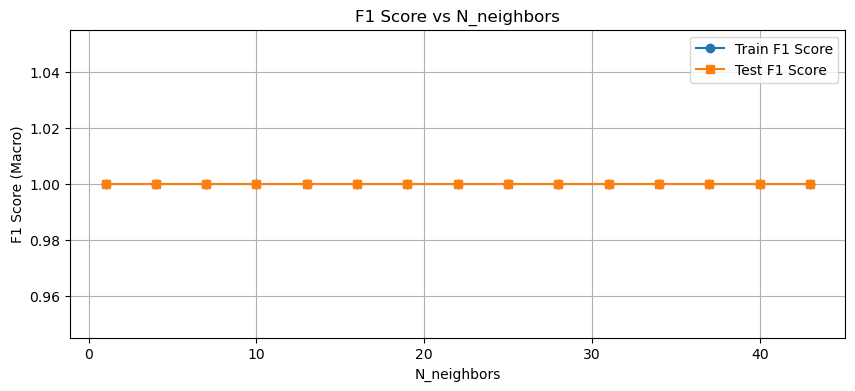

In [182]:
# Построение графика
plt.figure(figsize=(10, 4))
plt.plot(varying_range, train_scores, label='Train F1 Score', marker='o')
plt.plot(varying_range, test_scores, label='Test F1 Score', marker='s')
plt.xlabel(varying_param.capitalize())
plt.ylabel('F1 Score (Macro)')
plt.title(f'F1 Score vs {varying_param.capitalize()}')
plt.legend()
plt.grid()
plt.show()

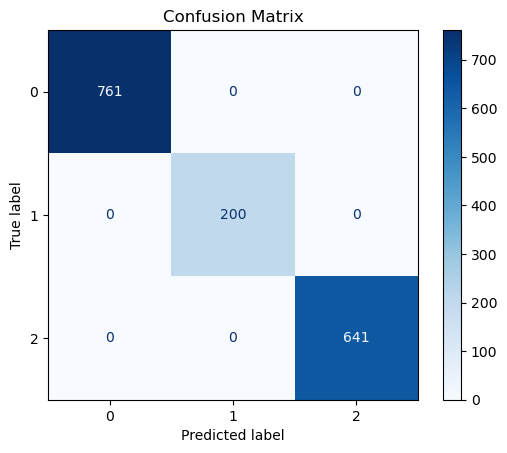

In [184]:
# Визуализация матрицы разбиения для тестовой выборки
cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [186]:
# Выполним кросс-валидацию с лучшими гиперпараметрами, найденными GridSearchCV
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_knn, X_train_np, y_train_np, cv=cv_strategy, scoring='f1_macro')

# Вывод результатов
print("F1 Score (Macro Average) для каждой итерации кросс-валидации:", cv_scores)
print("Средний F1 Score (Macro Average):", cv_scores.mean())

F1 Score (Macro Average) для каждой итерации кросс-валидации: [1. 1. 1. 1. 1.]
Средний F1 Score (Macro Average): 1.0


In [188]:
# 1. Пропорции классов и корректировка весов
class_counts = Counter(y_train)
total_count = len(y_train)
class_distribution = {cls: count / total_count for cls, count in class_counts.items()}
class_weights = {cls: total_count / (count * class_distribution[cls]) for cls, count in class_counts.items()}

# 2. Функция для применения LOWESS с учетом весов по классам
def apply_weighted_lowess(X, y, class_weights, frac=0.01):
    X_smooth = X.copy()  # Используем копию оригинальных данных

    for col in range(X.shape[1]):
        # Получаем веса для текущего столбца
        weights = np.array([class_weights.get(cls, 1) for cls in y])
        
        # Нормируем веса
        weights /= np.sum(weights)

        # Применяем LOWESS без весов
        smooth = lowess(X.iloc[:, col], np.arange(len(X)), frac=frac)

        # Применяем веса для коррекции
        X_smooth.iloc[:, col] = (weights * smooth[:, 1]) + ((1 - weights) * X.iloc[:, col])
        
    return X_smooth

# 3. Функция для выявления аномалий с адаптивным порогом
def detect_anomalies_adaptive(X, X_smooth, num_std_dev=1):
    errors = np.mean((X - X_smooth) ** 2, axis=1)
    threshold = np.mean(errors) + num_std_dev * np.std(errors)
    return errors > threshold

# 4. Применим LOWESS для сглаживания данных с учетом весов
X_train_smooth = apply_weighted_lowess(X_train, y_train, class_weights)
X_test_smooth = apply_weighted_lowess(X_test, y_test, class_weights)

# 5. Оценим результат валидации до взвешивания
train_mse = mean_squared_error(X_train, X_train_smooth)
test_mse = mean_squared_error(X_test, X_test_smooth)

print("Ошибка на обучающем множестве до взвешивания:", train_mse)
print("Ошибка на тестовом множестве до взвешивания:", test_mse)

# 6. Функция для расчета взвешенной MSE на основе классовых весов
def weighted_mse(X, X_smooth, y, class_weights):
    errors = (X - X_smooth) ** 2
    weighted_errors = np.array([errors[i] * class_weights.get(y.iloc[i], 1) for i in range(len(y))])
    return np.mean(weighted_errors)

# 7. Вычисление ошибки после взвешивания
train_mse_weighted = weighted_mse(X_train.values, X_train_smooth.values, y_train, class_weights)
test_mse_weighted = weighted_mse(X_test.values, X_test_smooth.values, y_test, class_weights)

print("Ошибка на обучающем множестве после взвешивания:", train_mse_weighted)
print("Ошибка на тестовом множестве после взвешивания:", test_mse_weighted)

# 8. Определение аномалий с адаптивным порогом
train_anomalies = detect_anomalies_adaptive(X_train.values, X_train_smooth.values)
test_anomalies = detect_anomalies_adaptive(X_test.values, X_test_smooth.values)

# print("Аномалии в обучающем наборе:", np.where(train_anomalies)[0])
# print("Аномалии в тестовом наборе:", np.where(test_anomalies)[0])
print("Количество аномалий в обучающем наборе:", np.sum(train_anomalies))
print("Количество аномалий в тестовом наборе:", np.sum(test_anomalies))

Ошибка на обучающем множестве до взвешивания: 3.936992619329129e-08
Ошибка на тестовом множестве до взвешивания: 8.210598788921864e-08
Ошибка на обучающем множестве после взвешивания: 2.2050325502070616e-06
Ошибка на тестовом множестве после взвешивания: 4.582655132117381e-06
Количество аномалий в обучающем наборе: 273
Количество аномалий в тестовом наборе: 182
